In [1]:
#Importing necessary libraries

import random
import pandas as pd
import numpy as np
import io
import re
import json
import unicodedata
from keras.layers import Input, LSTM, Dense, Embedding
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences, plot_model

# Adding the path to the current input
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/frenchenglish-bilingual-pairs/_about.txt
/kaggle/input/frenchenglish-bilingual-pairs/fra.txt
/kaggle/input/frenchenglish-bilingual-pairs/fra-eng/_about.txt
/kaggle/input/frenchenglish-bilingual-pairs/fra-eng/fra.txt


In [49]:
# Opening the dataset and reading all the lines into list

with io.open('/kaggle/input/frenchenglish-bilingual-pairs/fra-eng/fra.txt', 'r', encoding = 'utf-8') as file:
    data = [line for line in file]
print(f'Number of train and test sentences combined: {len(data)}')
print(f'First three raw input: {data[:3]}')

# Creating train and test data from the given corpus
required_test_sample_len = 10000

# Randomly picking sentences and removing them from actual dataset
random.seed(1)
test_data = random.sample(data, required_test_sample_len)
for sentence in test_data:
    data.remove(sentence)

# Printing all the data

print(f'Length of testing data: {len(test_data)}')
print(f'Length of training data: {len(data)}')

# Separation of each english and french sentences for test set

inputs_text = [line.split('\t')[1].rstrip() for line in data]
target_text = [line.split('\t')[0] for line in data]

print(f'Raw French Input: {inputs_text[:3]}')
print(f'Raw English output: {target_text[:3]}')

# Text preprocessing with unicode normalization and substitution of punctuation for test set

def text_preprocessing(text):

    #Normalising all unicode characters into a single recognisable characters
    text = ''.join([word for word in unicodedata.normalize('NFD', text) if unicodedata.category(word) != 'Mn'])

    #Substituing all the punctuations except the sentence ending characters
    text = re.sub(r'([!?.,]+)', r' \1 ', text)
    text = re.sub(r'["  "]+', ' ', text)
    text = text.lower().replace('\u202f', '').strip()

    return text

#Applying the the preprocessing function in each sentence
input_french_preprocessed = [text_preprocessing(line) for line in inputs_text]
output_eng_preprocessed = [text_preprocessing(line) for line in target_text]


print(f'Preprocessed French Input: {input_french_preprocessed[:3]}')
print(f'Preprocessed English output: {output_eng_preprocessed[:3]}')

# Adding <sos> and <eos> tokens in target english sentences with a function for test set

def target_tagging(text_list):
    return list(map(lambda x: '<sos> ' + x + ' <eos>', text_list))

output_eng_tagged = target_tagging(output_eng_preprocessed)

print(f'Token tagged English output: {output_eng_tagged[:3]}')

Number of train and test sentences combined: 145437
First three raw input: ['Go.\tVa !\n', 'Run!\tCours\u202f!\n', 'Run!\tCourez\u202f!\n']
Length of testing data: 10000
Length of training data: 135437
Raw French Input: ['Va !', 'Cours\u202f!', 'Courez\u202f!']
Raw English output: ['Go.', 'Run!', 'Run!']
Preprocessed French Input: ['va !', 'cours !', 'courez !']
Preprocessed English output: ['go .', 'run !', 'run !']
Token tagged English output: ['<sos> go . <eos>', '<sos> run ! <eos>', '<sos> run ! <eos>']


In [50]:
#Creating french tokenizer for each words
fre_tokenizer = Tokenizer(oov_token='<unk>', filters = '"#$%&()*+-/:;=@[\\]^_`{|}~\t\n«»')
fre_tokenizer.fit_on_texts(input_french_preprocessed)

french_vocab_size = len(fre_tokenizer.word_index) + 1
print(f'Number of unique words in French corpus: {french_vocab_size}')

#Creating english tokenizer for each words
eng_tokenizer = Tokenizer(oov_token='<unk>', filters = '"#$%&()*+-/:;=@[\\]^_`{|}~\t\n')
eng_tokenizer.fit_on_texts(output_eng_tagged)

english_vocab_size = len(eng_tokenizer.word_index) + 1
print(f'Number of unique words in English corpus: {english_vocab_size}')

#Fitting the corpus in the dataset for input
train_encoder_input = fre_tokenizer.texts_to_sequences(input_french_preprocessed)

#Creating two tagged idecoder input and output
def tagged_decoder_generator(tokenizer, sentence_list):
    tagged_output = tokenizer.texts_to_sequences(sentence_list)
    decoder_input = [tag[:-1] for tag in tagged_output]
    decoder_output = [tag[1:] for tag in tagged_output]

    return decoder_input, decoder_output

train_decoder_input, train_decoder_output = tagged_decoder_generator(eng_tokenizer, output_eng_tagged)

print(f'First few encoder training input: {train_encoder_input[:5]}')
print(f'First few decoder training input: {train_decoder_input[:5]}')
print(f'First few decoder training output: {train_decoder_output[:5]}')


#Max len of sentences
max_encoder_input_len = max([len(sentence) for sentence in train_encoder_input])
max_decoder_input_len = max([len(sentence) for sentence in train_decoder_input])
max_decoder_output_len = max([len(sentence) for sentence in train_decoder_output])

print(f'Max encoder input sentence length: {max_encoder_input_len}')
print(f'Max decoder input sentence length: {max_decoder_input_len}')
print(f'Max decoder output sentence length: {max_decoder_output_len}')

#Padding all three seqs with the max len of sentences
padded_encoder_input = pad_sequences(train_encoder_input, maxlen = max_encoder_input_len, padding = 'post', truncating='post')
padded_decoder_input = pad_sequences(train_decoder_input, maxlen = max_decoder_input_len, padding = 'post', truncating='post')
padded_decoder_output = pad_sequences(train_decoder_output, maxlen = max_decoder_output_len, padding = 'post', truncating='post')

print(f'First encoder padded input: {padded_encoder_input[:1]}')
print(f'First decoder padded input: {padded_decoder_input[:1]}')
print(f'First decoder padded output: {padded_decoder_output[:1]}')

Number of unique words in French corpus: 25065
Number of unique words in English corpus: 13514
First few encoder training input: [[119, 29], [612, 29], [4945, 29], [34, 370, 29], [46, 458, 29]]
First few decoder training input: [[2, 49, 4], [2, 408, 118], [2, 408, 118], [2, 3670, 118], [2, 473, 118]]
First few decoder training output: [[49, 4, 3], [408, 118, 3], [408, 118, 3], [3670, 118, 3], [473, 118, 3]]
Max encoder input sentence length: 58
Max decoder input sentence length: 53
Max decoder output sentence length: 53
First encoder padded input: [[119  29   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]]
First decoder padded input: [[ 2 49  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0]]
First dec

In [51]:
# cleanining and generating test data for validation of the trained model

def test_data_generator(test_list):

    # creating test input (french) and target(english) sentence list
    test_input = []
    test_target = []
    for sentence in test_list:
        target, input = sentence.split('\t')
        test_input.append(input)
        test_target.append(target.rstrip())
    
    # applying previous text preprocessing function for cleaning
    input_french_test = [text_preprocessing(line) for line in test_input]
    output_eng_test = [text_preprocessing(line) for line in test_target]

    # Adding <sos> and <eos> tokens in target sentences
    tagged_test_output = target_tagging(output_eng_test)

    # creating new encoder input for test set
    test_encoder_input = fre_tokenizer.texts_to_sequences(input_french_test)

    # creating new two tagged decoder input and output for test set
    test_decoder_input, test_decoder_output = tagged_decoder_generator(eng_tokenizer, tagged_test_output)

    # creating padded encoder and decoder input and output test set
    encoder_input_padded = pad_sequences(test_encoder_input, maxlen = max_encoder_input_len, padding = 'post', truncating='post')
    decoder_input_padded = pad_sequences(test_decoder_input, maxlen = max_decoder_input_len, padding = 'post', truncating='post')
    decoder_output_padded = pad_sequences(test_decoder_output, maxlen = max_decoder_output_len, padding = 'post', truncating='post')

    return encoder_input_padded, decoder_input_padded, decoder_output_padded


# output generation from the test list
test_encoder_input_padded, test_decoder_input_padded, test_decoder_output_padded = test_data_generator(test_data)

print(f'First test encoder padded input: {test_encoder_input_padded[:1]}')
print(f'First test decoder padded input: {test_decoder_input_padded[:1]}')
print(f'First test decoder padded output: {test_decoder_output_padded[:1]}')

First test encoder padded input: [[  24  310   44 1663    2    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]
First test decoder padded input: [[   2    5   22  260   25 1396    4    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]
First test decoder padded output: [[   5   22  260   25 1396    4    3    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0]]


Model: "french_english_translator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input_layer (Input  [(None, None)]               0         []                            
 Layer)                                                                                           
                                                                                                  
 decoder_input_layer (Input  [(None, None)]               0         []                            
 Layer)                                                                                           
                                                                                                  
 encoder_embedding_layer (E  (None, None, 256)            6416640   ['encoder_input_layer[0][0]'] 
 mbedding)                                                                

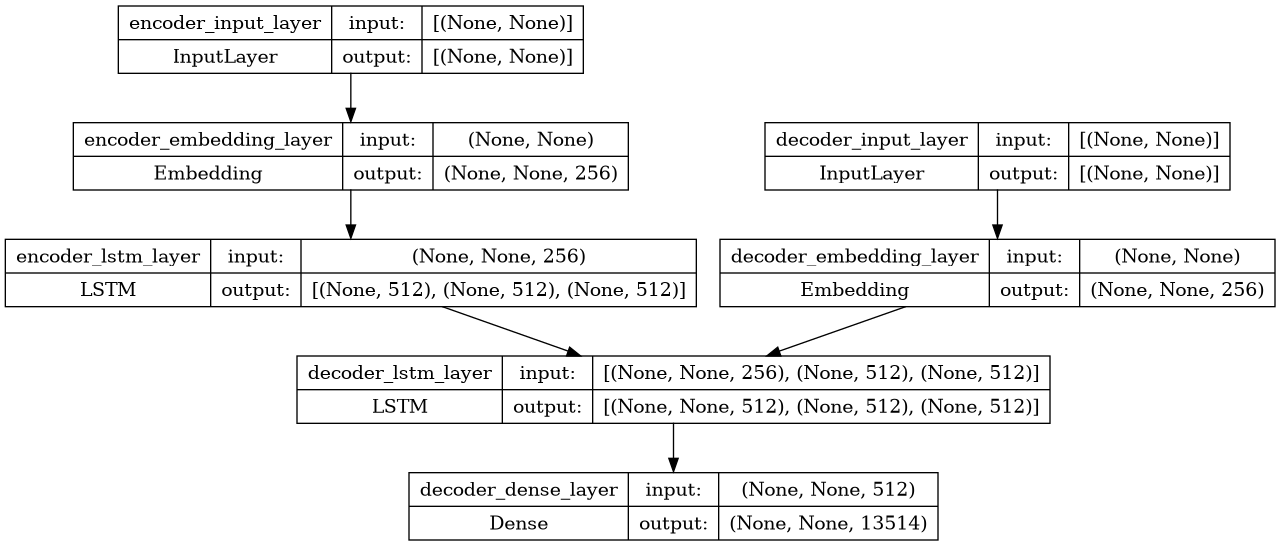

In [52]:
# -----------------Model building-----------------

# Necessary parameters for model building
embedding_dim = 256
lstm_dim = 512
dropout = 0.20
epochs = 20
batch_size = 32


# -----------------Encoder model parts-----------------


# Encoder Input layer
encoder_input_layer = Input(shape = [None],
                            name = 'encoder_input_layer')

# Encoder Embedding layyer
encoder_embedding_layer = Embedding(input_dim = french_vocab_size,
                                    output_dim=embedding_dim,
                                    mask_zero=True,
                                    name = 'encoder_embedding_layer')

# Connecting Embedding layer to the input layer
encoder_embedding_output = encoder_embedding_layer(encoder_input_layer)

# Encoder LSTM layer
encoder_lstm_layer = LSTM(units = lstm_dim,
                          return_state=True,
                          dropout=dropout,
                          name = 'encoder_lstm_layer')


# Connecting Encoder lstm layer to embedding layer
_, state_eh, state_ec = encoder_lstm_layer(encoder_embedding_output)

#First lstm states
encoder_lstm_state = (state_eh, state_ec)


# -----------------Decoder Model parts-----------------


#Decoder Input layer
decoder_input_layer = Input(shape = [None], name = 'decoder_input_layer')

#Decoder Embedding layer
decoder_embedding_layer = Embedding(input_dim=english_vocab_size,
                                    mask_zero = True,
                                    output_dim=embedding_dim,
                                    name = 'decoder_embedding_layer')

# Connecting Decoder first lstm layer to embedding layer
decoder_embedding_output = decoder_embedding_layer(decoder_input_layer)

# Decoder first LSTM layer
decoder_lstm_layer = LSTM(units = lstm_dim,
                            return_sequences=True,
                            return_state=True,
                            dropout = dropout,
                            name = 'decoder_lstm_layer')

# Connecting Decoder first lstm layer to embedding layer
decoder_lstm_output, state_dh, state_dc = decoder_lstm_layer(decoder_embedding_output, initial_state=encoder_lstm_state)

# Decoder lstm states
decoder_lstm_state = (state_dh, state_dc)

# Deconder Dense layer
decoder_dense_layer = Dense(units = english_vocab_size, activation= 'softmax', name = 'decoder_dense_layer')

# Connecting Decoder lstm layer to dense layer
decoder_probability_output = decoder_dense_layer(decoder_lstm_output)

# Building and Compiling the encoder-decoder model
model = Model([encoder_input_layer, decoder_input_layer], decoder_probability_output, name = 'french_english_translator')

model.compile(optimizer= 'adam', loss = 'sparse_categorical_crossentropy', metrics = 'sparse_categorical_accuracy')

model.summary()

# Plotting the model
plot_model(model, show_layer_names= True, show_shapes=True)

In [53]:
# Creating Modelcheckpoint to save the best model
cp_callbacks = ModelCheckpoint(filepath='weights_models.ckpt',
                               monitor = 'val_loss',
                               verbose = 1)

# Creating earlystopping to thresshold the incresing validation loss
es_callbacks = EarlyStopping(monitor = 'val_loss', patience = 3)


# Fitting the model
model.fit(x = [padded_encoder_input, padded_decoder_input], y = padded_decoder_output,
          batch_size=batch_size,
          epochs = epochs,
          validation_data=([test_encoder_input_padded, test_decoder_input_padded], test_decoder_output_padded),
          callbacks=[cp_callbacks, es_callbacks])

# Saving the final model

model.save('French_English_Translator')

# Saving the french tokenizer as json file

fre_tokenizer_json = fre_tokenizer.to_json()

with io.open('fre_tokenizer.json', 'w', encoding = 'utf-8') as file:
    file.write(json.dumps(fre_tokenizer_json, ensure_ascii=False))

# Saving the english tokenizer as json file

eng_tokenizer_json = eng_tokenizer.to_json()

with io.open('eng_tokenizer.json', 'w', encoding = 'utf-8') as file:
    file.write(json.dumps(eng_tokenizer_json))

Epoch 1/20
4233/4233 [==============================] - ETA: 0s - loss: 3.3682 - sparse_categorical_accuracy: 0.4337
Epoch 1: saving model to weights_models.ckpt
4233/4233 [==============================] - 248s 56ms/step - loss: 3.3682 - sparse_categorical_accuracy: 0.4337 - val_loss: 2.4549 - val_sparse_categorical_accuracy: 0.5558
Epoch 2/20
4233/4233 [==============================] - ETA: 0s - loss: 1.9557 - sparse_categorical_accuracy: 0.6216
Epoch 2: saving model to weights_models.ckpt
4233/4233 [==============================] - 221s 52ms/step - loss: 1.9557 - sparse_categorical_accuracy: 0.6216 - val_loss: 1.7156 - val_sparse_categorical_accuracy: 0.6718
Epoch 3/20
4233/4233 [==============================] - ETA: 0s - loss: 1.2909 - sparse_categorical_accuracy: 0.7249
Epoch 3: saving model to weights_models.ckpt
4233/4233 [==============================] - 223s 53ms/step - loss: 1.2909 - sparse_categorical_accuracy: 0.7249 - val_loss: 1.4049 - val_sparse_categorical_accuracy:

In [ ]:
# If the model is trained already the following code will just import the model and run the json tokenizers
# (Only if the model is already trained)

# Loading the model from the folder
#model = load_model('French_English_Translator')

# Loading the french tokenizer from json file
#with io.open('fre_tokenizer.json', 'r', encoding = 'utf-8') as file:
#    fre_tokenizer_loaded = json.load(file)

# Loading the english tokenizer from json file
#with io.open('eng_tokenizer.json', 'r', encoding = 'utf-8') as file:
#    eng_tokenizer_loaded = json.load(file)

Layer names: ['encoder_input_layer', 'decoder_input_layer', 'encoder_embedding_layer', 'decoder_embedding_layer', 'encoder_lstm_layer', 'decoder_lstm_layer', 'decoder_dense_layer']


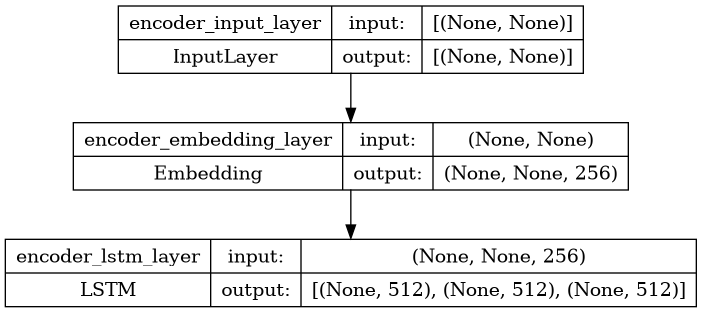

In [58]:
# Inference Model from the trained layers

# Getting the layers of primary model
layer_names = [layer.name for layer in model.layers]
print(f'Layer names: {layer_names}')

# -----Encoder part------

# Inference encoder input layer
infer_encoder_input = model.get_layer('encoder_input_layer').input

# Inference encoder embedding layer
infer_encoder_embedding = model.get_layer('encoder_embedding_layer')

# Connecting inference encoder input layer to inference encoder embedding layer
infer_encoder_embedding_output = infer_encoder_embedding(infer_encoder_input)

# Inference encoder lstm layer
infer_encoder_lstm = model.get_layer('encoder_lstm_layer')

# Connecting inference encoder lstm layer to inference encoder embedding layer
_, state_h, state_c = infer_encoder_lstm(infer_encoder_embedding_output)
infer_lstm_state = [state_h, state_c]

# Adding everything in a final encoder model
infer_encoder_model = Model(infer_encoder_input, infer_lstm_state)

# Plotting the final encoder inference model
plot_model(infer_encoder_model, show_layer_names= True, show_shapes= True)


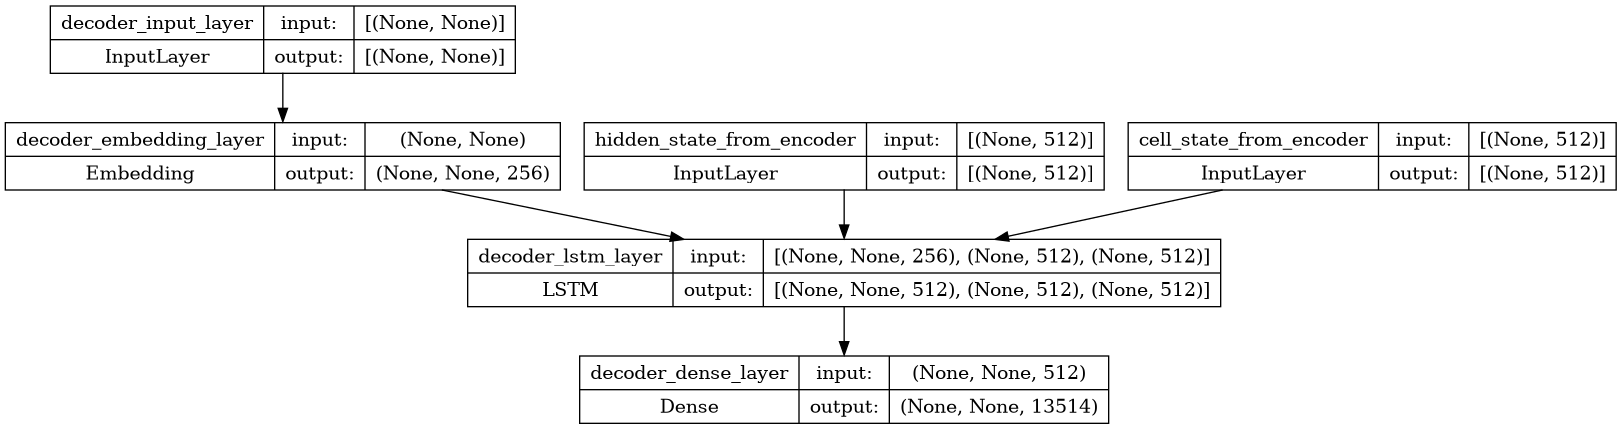

In [59]:
# -----Decoder part------

# Inference decoder input layer
infer_decoder_input = model.get_layer('decoder_input_layer').input

# Inference decoder embedding layer
infer_decoder_embedding = model.get_layer('decoder_embedding_layer')

# Connecting inference decoder input layer to inference decoder embedding layer
infer_decoder_embedding_output = infer_decoder_embedding(infer_decoder_input)

# Inference decoder first lstm layer
infer_decoder_lstm = model.get_layer('decoder_lstm_layer')

# Creating two separate layers to fit the states of encoder hidden and cell state
decoder_state_h_e = Input(shape = (lstm_dim,), name = 'hidden_state_from_encoder')
decoder_state_c_e = Input(shape = (lstm_dim,), name = 'cell_state_from_encoder')

infer_decoder_states = [decoder_state_h_e, decoder_state_c_e]

# Connecting inference decoder lstm layer to inference decoder embedding layer
infer_decoder_lstm_output, state_h_d, state_c_d = infer_decoder_lstm(infer_decoder_embedding_output, initial_state = infer_decoder_states)
infer_decoder_final_states = [state_h_d, state_c_d]

# Inference decoder dense layer
infer_decoder_dense = model.get_layer('decoder_dense_layer')

# Connecting inference decoder lstm layer to inference decoder second lstm layer
infer_decoder_final = infer_decoder_dense(infer_decoder_lstm_output)

# Adding everything in a final decoder model
infer_decoder_model = Model([infer_decoder_input] + infer_decoder_states, [infer_decoder_final] + infer_decoder_final_states)

# Plotting the final decoder inference model
plot_model(infer_decoder_model, show_layer_names= True, show_shapes= True)


In [62]:
# ------------Translation function with new inference model-----------------

Number_of_sentence = 15 #Not more than 10000

# Randomly choosing 15 sentences to translate
random.seed(1)
sample_test_data = random.sample(test_data, Number_of_sentence)

#Creating function to translate one sentence at a time
def translation_with_inference_model(sentence: str, source_tokenizer, encoder, target_tokenizer, decoder, max_target_sen_len = 60):

    # Converting an input sequence from source tokenizer
    input_seq = source_tokenizer.texts_to_sequences([sentence])

    # Gettting encoder to predict the intial state of each sentence
    intial_state = encoder.predict(input_seq)

    # Making the first token for further prediction
    current_word = '<sos>'
    translated_sentences = []

    # Looping through the whole sequence until it goes to max target sentence length

    while len(translated_sentences) < max_target_sen_len:

        # Initialising the target seq with zeros
        target_seq = np.zeros(shape = (1,1))
        target_seq[0, 0] = target_tokenizer.word_index[current_word]

        # getting the index of predicted word from decoder and adding to the list unless it's eos token
        current_seq, h, c = decoder.predict([target_seq] + intial_state)
        current_seq_index = np.argmax(current_seq[0, -1, :])
        current_word = target_tokenizer.index_word[current_seq_index]

        # If the current word is end of string (eos) the loop will break
        if current_word == '<eos>':
            break

        translated_sentences.append(current_word)
        intial_state = [h, c]

    return ' '.join(translated_sentences)


def translation_into_dataframe(sentence_list, translation_function, source_tokenizer, encoder, target_tokenizer, decoder):

    # Creating a new dictionary for sentence dataframe
    translation_dict = {'French Sentence':[], 'Human Translation': [], 'Machine Translation': []}

    for sent in sentence_list:

        # Preprocessing of the sampled text
        target, source = sent.split('\t')
        preprocessed_text = text_preprocessing(source)

        translated_sentence = translation_function(preprocessed_text, source_tokenizer, encoder, target_tokenizer, decoder)

        translation_dict['French Sentence'].append(source.rstrip())
        translation_dict['Human Translation'].append(target)
        translation_dict['Machine Translation'].append(translated_sentence)

    df = pd.DataFrame(translation_dict)

    return df

translated_df = translation_into_dataframe(sample_test_data, translation_with_inference_model, fre_tokenizer, infer_encoder_model, eng_tokenizer, infer_decoder_model)

1/1 [==============================] - 0s 21ms/step


In [63]:
translated_df

,French Sentence,Human Translation,Machine Translation
0,Vous n'êtes pas trop en retard.,You're not too late.,you're not too late .
1,C'est plutôt incroyable.,It's pretty incredible.,this is pretty incredible .
2,Cette ville est réputée pour ses magnifiques j...,This city is famous for its beautiful park.,this town is famous for its famous .
3,Je coopérerai.,I'll cooperate.,i'll play along .
4,Nous allons manquer de faire ceci.,We're going to miss doing this.,we're going to have to do this .
5,Il me reste encore des choses à faire.,I still have things left to do.,i still have a lot of things to do .
6,Vous l'ai-je déjà dit ?,Did I tell you that already?,did i tell you that ?
7,Nous sommes restés dans un hôtel au bord du lac.,We stayed at a hotel by the lake.,we stayed at a hotel in the lake .
8,On n'en ressort que ce qu'on y a introduit.,You get out only what you put in.,you get out only what you put in .
9,C'est l'homme parfait pour toi.,He's the perfect man for you.,this is the perfect man for you .


**The Translation are pretty close and most of them are replaced with some synonyms as well since embeddings were used. However, some issues can be spotted as well. With more training data and more number of layers can accomplish more accurate results.**